# Домашнее задание 3. Свёрточные и рекуррентные нейронные сети

### Хрулева Елена ИУ8-83
### Вариант 19

## Наборы данных

### Задача регрессии

D. Набор данных "Кошки и собаки" torchvision.datasets.OxfordIIITPet split = 'trainval' и 'test' (объекты разбиты по породам (всего 37 пород), нужно построить бинарный классификатор собак и кошек)

### Задача классификации

N. Набор данных "Сказки" fairytales.txt

## 2. Рекуррентная нейронная сеть для генерации текстов

### 2.1 Загрузка данных

In [1]:
import warnings
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import collections

warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open("N_fairytales.txt", 'r', encoding='utf-8') as fairytales:
    lines = fairytales.readlines()

lines = lines[53:]

In [2]:
clear_lines = []
fairytales = str()
for line in lines:
    line = line.replace('\n', '')

    if len(line) and line != line.upper():
        fairytales += line.replace('   ', '\n')

### 2.2 Преодбработка/нормализация данных по необходимости

Например, можно привести все слова к нижнему регистру

In [3]:
collection = sorted(
    collections.Counter(fairytales).items(),
    key = lambda i: i[1],
    reverse = True
)

In [4]:
char_map =  {j[0]: i for i, j in enumerate(collection)}
index_map = {j: i for i, j in char_map.items()}
ft_seq = np.array([char_map[i] for i in fairytales])

### 2.3 Инициализация объекта рекуррентной нейронной сети

In [5]:
class TextModel1(torch.nn.Module):
    def __init__(self, num_emb, emb_dim, hidden_size, num_layers, dropout):
        super().__init__()

        self.emb = torch.nn.Embedding(num_emb, emb_dim)
        self.rnn = torch.nn.RNN(emb_dim, hidden_size, num_layers, dropout=dropout)
        self.l_1 = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.d_1 = torch.nn.Dropout(0.2)
        self.l_2 = torch.nn.Linear(hidden_size // 2, hidden_size // 4)
        self.d_2 = torch.nn.Dropout(0.2)
        self.l_3 = torch.nn.Linear(hidden_size // 4, num_emb)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x, h):
        x = self.emb(x).squeeze(2)
        x, h = self.rnn(x, h)
        
        x = self.d_1(self.l_1(x))
        x = self.d_2(self.l_2(x))
        x = self.l_3(x)
        return x, h
    
    def init_state(self, batch_size=1):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device)

In [6]:
def eval(model, input_text, length, temp):
    model.eval()

    x = torch.LongTensor(tuple((char_map[c] for c in input_text)))
    x = x.view(-1, 1, 1).to(device)

    with torch.no_grad():
        hidden = model.init_state(batch_size=1)
        _, hidden = model.forward(x, hidden)
        x = x[-1].view(-1, 1, 1)

        for symbol in range(length):
            y, hidden = model.forward(x, hidden)
            y = y.cpu().data.view(-1) / temp
            
            p = torch.nn.functional.softmax(y, dim=-1)
            p = p.detach().cpu().data.numpy()
            i = np.random.choice(len(char_map), p=p)
            input_text += index_map[i]
            x = torch.LongTensor([i])
            x = x.view(-1, 1, 1).to(device)
    return input_text

In [7]:
def get_train_data(batch_size=20, length=250):
    x = list()
    y = list()

    for _ in range(20):
        rand_i = np.random.randint(0, len(ft_seq) - 250)
        x_i = torch.LongTensor(ft_seq[rand_i:rand_i + 250 - 1])
        x.append(x_i.view(-1, 1))
        y_i = torch.LongTensor(ft_seq[rand_i + 1:rand_i + 250])
        y.append(y_i.view(-1, 1))

    x = torch.stack(x, dim=0).permute(1, 0, 2).to(device)
    y = torch.stack(y, dim=0).permute(1, 0, 2).to(device)
    return x, y

In [8]:
def train_model(model, criterion, optimizer, scheduler, epochs=10_000):
    losses = list()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        x, y = get_train_data(ft_seq)
        h = model.init_state(20)
        
        y_pred, _ = model.forward(x, h)
        loss = criterion(y_pred.permute(1, 2, 0), y.squeeze(-1).permute(1, 0))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        if epoch == 0 or epoch % 500 == 499:
            print(f"{epoch + 1}) CrossEntropyLoss={round(losses[-1], 2)}")

    return losses

### 2.4 Обучение обычной рекуррентной нейронной сети

In [9]:
model = TextModel1(len(char_map), 128, 256, 3, 0.2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, factor=0.1)

losses = train_model(model, criterion, optimizer, scheduler)

1) CrossEntropyLoss=4.58
500) CrossEntropyLoss=2.09
1000) CrossEntropyLoss=1.84
1500) CrossEntropyLoss=1.78
2000) CrossEntropyLoss=1.74
2500) CrossEntropyLoss=1.78
3000) CrossEntropyLoss=1.75
3500) CrossEntropyLoss=1.64
4000) CrossEntropyLoss=1.66
4500) CrossEntropyLoss=1.61
5000) CrossEntropyLoss=1.63
5500) CrossEntropyLoss=1.64
6000) CrossEntropyLoss=1.64
6500) CrossEntropyLoss=1.6
7000) CrossEntropyLoss=1.55
7500) CrossEntropyLoss=1.61
8000) CrossEntropyLoss=1.53
8500) CrossEntropyLoss=1.55
9000) CrossEntropyLoss=1.64
9500) CrossEntropyLoss=1.56
10000) CrossEntropyLoss=1.6


### 2.5 Генерация текстов при помощи обычной рекуррентной сети

In [10]:
for temp_i in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    pred_text = eval(model, "Жил-был король с королевой, и у них", 500, temp_i)
    print(f"Temp={temp_i}: {pred_text}")
    print()

Temp=0.1: Жил-был король с королевой, и у них не спросила его в ней и сказала:
- Не было не стала она подошел к ней и сказала:
- Не было не стала она подошла к нему в королевской дочь великана со своей дочери.
- Нет, - сказала королева совсем не стала она старуха со своей дочери, и она совсем не стала не стала сердце старуха стала она со своей королевского дерева и сказала:
- Не было в том столом и сказала:
- Не после тебе не последний дочь великана солнце не последняя королева со своей дочери. Она совсем не подошла к нему в своей королевс

Temp=0.2: Жил-был король с королевой, и у них под ним старуха совсем не спросила его с собой королева и сказала:
- Не станет в королевского королевство  последняя  королевство  отправился  всего  старуха  она  стала  все  старуха  старшая  королевство  всего  старуха  она  отправился  возвращаться  семь  домой  старуха  всего  принцессы  она  возвращается  старуха  старуха  подошла  в  тому  королевского  принцессы  не  всегда  все  во  дворце  пода

### 2.6 Обучение рекуррентной нейронной сети с LSTM-ячейками

In [11]:
class TextModel2(torch.nn.Module):
    def __init__(self, num_emb, emb_dim, hidden_size, num_layers, dropout):
        super().__init__()

        self.emb = torch.nn.Embedding(num_emb, emb_dim)
        self.rnn = torch.nn.LSTM(emb_dim, hidden_size, num_layers, dropout=dropout)
        self.l_1 = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.d_1 = torch.nn.Dropout(0.2)
        self.l_2 = torch.nn.Linear(hidden_size // 2, hidden_size // 4)
        self.d_2 = torch.nn.Dropout(0.2)
        self.l_3 = torch.nn.Linear(hidden_size // 4, num_emb)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x, h):
        x = self.emb(x).squeeze(2)
        x, h = self.rnn(x, h)
        
        x = self.d_1(self.l_1(x))
        x = self.d_2(self.l_2(x))
        x = self.l_3(x)
        return x, h
    
    def init_state(self, batch_size=1):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device))

In [12]:
model = TextModel2(len(char_map), 128, 256, 3, 0.2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, factor=0.1)

losses_2 = train_model(model, criterion, optimizer, scheduler)

1) CrossEntropyLoss=4.54
500) CrossEntropyLoss=2.25
1000) CrossEntropyLoss=1.89
1500) CrossEntropyLoss=1.76
2000) CrossEntropyLoss=1.65
2500) CrossEntropyLoss=1.54
3000) CrossEntropyLoss=1.46
3500) CrossEntropyLoss=1.45
4000) CrossEntropyLoss=1.47
4500) CrossEntropyLoss=1.36
5000) CrossEntropyLoss=1.34
5500) CrossEntropyLoss=1.26
6000) CrossEntropyLoss=1.3
6500) CrossEntropyLoss=1.26
7000) CrossEntropyLoss=1.23
7500) CrossEntropyLoss=1.16
8000) CrossEntropyLoss=1.17
8500) CrossEntropyLoss=1.16
9000) CrossEntropyLoss=1.15
9500) CrossEntropyLoss=1.16
10000) CrossEntropyLoss=1.14


### 2.7 Генерация текстов с разной температурой

Попробуйте сгенерировать тексты с температурой из списка: [0.1, 0.2, 0.4, 0.6, 0.8, 1.0] (см. нотубук с семинара по RNN)

In [13]:
for temp_i in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    pred_text = eval(model, "Жил-был король с королевой, и у них", 500, temp_i)
    print(f"Temp={temp_i}: {pred_text}")
    print()

Temp=0.1: Жил-был король с королевой, и у них не подал и  страшно,  что  онаподумала: "Чудовище, - сказал король. -  Но  тыне спускай девушка, но он не смог надеть только какая-то  травка,  как  ты  скажешь,что ты не сможешь тебе посмотреть, что на свете  принцесса  вы-соты добралась в прохладную постель.
- Нет, - сказал король. - Я не могу поставить  вас  возвращаетесьвдруг все своего дорога, то принесла там от боли и пришла к  своейпринцессой. Она собрала с собой в спрятую старую королевну, и они  подумали,  что  онаподумала: "Пожалуйста

Temp=0.2: Жил-был король с королевой, и у них не подозревал,  принцесса  вспомнила  их  впала  всесобще и принесла она в своей каморке. Она сказала:
- Не надо, - сказал солдат. - Но ведь он должен  вер-нуться к своей жене, - сказал он. - Но ты скоро умер.
После обеда мать и как следует свою работу. Она сказала:
- Я не вернулась в одной королевской старой девушкой. Она сказала:
- Я не знаю, что в том свете не пришлось у меня самыми словами, но он не 

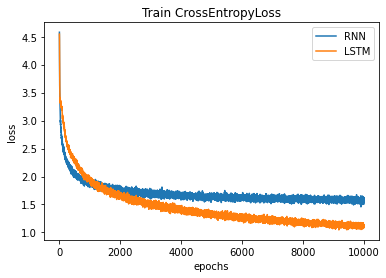

In [14]:
plt.plot(losses, label="RNN")
plt.plot(losses_2, label="LSTM")
plt.title("Train CrossEntropyLoss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### 2.8 Выводы

Задача задания №2 - обучить модель AI генерировать текст в стиле сказок.

Были обучены две модели, использующие в своих архитектурах рекуррентные нейронные сети. Первая модель использует RNN, вторая - LSTM.

Из-за того, что относительная невосприимчивость к длительности временных разрывов даёт LSTM преимущество по отношению к альтернативным рекуррентным нейронным сетям, можно предположить, что LSTM должно дать более качественный результат, чем модель на базе обычных RNN-слоев.

По графику после обучения моделей, видно, что LSTM значительно превосходит RNN в задаче генерации текста (loss падает куда интенсивнее).

Текст, который сгенерировала LSTM-модель, оказался куда более "натуральным", в сравнении с RNN-моделью.